In [1]:
# importing packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import re
import scipy.stats 

# obtaining the data
viewing_data = pd.read_csv('/kaggle/input/viewing-activity/ViewingActivity.csv')
user_data = viewing_data[viewing_data['Profile Name'] == 'TATIANA'].copy()
user_data.head(4)

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
16588,TATIANA,2025-01-21 19:02:42,00:00:03,Autoplayed: user action: None;,Amor sem Idade: Temporada 1: Um pequeno moment...,NaN,Netflix Chrome MAC (Cadmium) HTML 5,00:00:09,00:00:09,NL (Netherlands)
16589,TATIANA,2025-01-21 18:24:10,00:38:31,NaN,Amor sem Idade: Temporada 1: Entenderam? (Epis...,NaN,Netflix Chrome MAC (Cadmium) HTML 5,00:38:23,00:38:23,NL (Netherlands)
16590,TATIANA,2025-01-21 17:42:35,00:41:32,NaN,Amor sem Idade: Temporada 1: Me arrepia toda (...,NaN,Netflix Chrome MAC (Cadmium) HTML 5,00:41:38,00:41:38,NL (Netherlands)
16591,TATIANA,2025-01-21 17:32:29,00:10:05,NaN,Amor sem Idade: Temporada 1: Dwayna sabe das c...,NaN,Netflix Chrome MAC (Cadmium) HTML 5,00:40:40,00:40:40,NL (Netherlands)


In [2]:
# changing data types for date and time columns
user_data['Start Time'] = pd.to_datetime(user_data['Start Time'])
user_data['Duration'] = pd.to_timedelta(user_data['Duration'])
user_data['Bookmark'] = pd.to_datetime(user_data['Bookmark'])

user_data.dtypes

<ipython-input-2-f3e428b9223b>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  user_data['Bookmark'] = pd.to_datetime(user_data['Bookmark'])


Profile Name                        object
Start Time                  datetime64[ns]
Duration                   timedelta64[ns]
Attributes                          object
Title                               object
Supplemental Video Type             object
Device Type                         object
Bookmark                    datetime64[ns]
Latest Bookmark                     object
Country                             object
dtype: object

In [3]:
# how much time was spent on netflix on each month over the years
# creating columns for month/year and year
user_data['month_year'] = user_data['Start Time'].dt.strftime('%Y-%m')
user_data['month'] = user_data['Start Time'].dt.month
user_data['year'] = user_data['Start Time'].dt.year
user_data.dtypes
# removing incomplete years (2015, 2025)
filtered_years = user_data[~user_data['year'].isin([2015, 2025])]
# adding up the durations whilst grouping per month/year
duration_total = filtered_years.groupby(['month', 'year'])['Duration'].sum()
# convert 'Duration' to total hours
duration_total_in_hours = duration_total.dt.total_seconds() / 3600
duration_total_in_hours

month  year
1      2016    72.276111
       2017    48.591111
       2018    22.670278
       2019    67.002222
       2020    80.808611
                 ...    
12     2020    55.830000
       2021    43.746389
       2022    13.456667
       2023     8.120833
       2024    39.959167
Name: Duration, Length: 108, dtype: float64

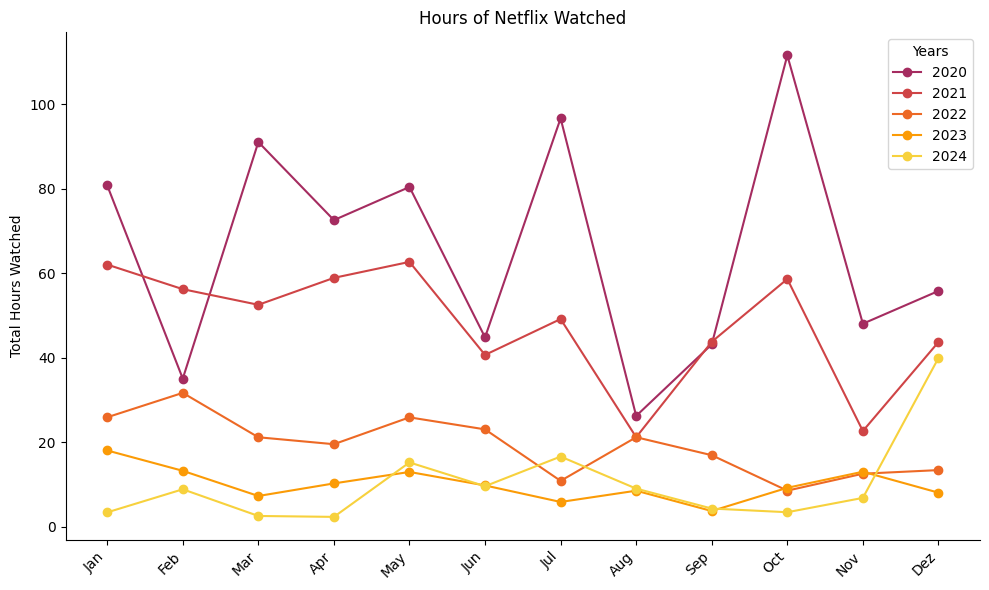

In [27]:
# graph showing only selected years (2020 to 2024)
recent_years = user_data[user_data['year'].isin([2020, 2021, 2022, 2023, 2024])]
duration_recent = recent_years.groupby(['month', 'year'])['Duration'].sum()
duration_recent = duration_recent.dt.total_seconds() / 3600
plt.figure(figsize=(10, 6))
norm = plt.Normalize(vmin= 2016, vmax=2025)
for year in duration_recent.index.get_level_values('year').unique():
    # Filter the data for the current year
    data_year = duration_recent.xs(year, level='year')
    plt.plot(data_year.index, data_year, marker='o', label=str(year), color=plt.get_cmap('inferno')(norm(year)))  # Plot with markers

# customize the plot
names_months = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dez']
plt.title('Hours of Netflix Watched')
plt.ylabel('Total Hours Watched')
plt.xticks(ticks = range(1,13), labels = names_months, rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Years', loc = 'upper right')  # Add legend for each year
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("hours_watched.jpg", dpi=300)

In [35]:
# meauring the decrease of watch time over the years
total_watchtime_year = user_data.groupby('year')['Duration'].sum()
df_total_watchtime_year = pd.DataFrame(total_watchtime_year.dt.total_seconds() / 3600)
df_total_watchtime_year['next_value'] = df_total_watchtime_year['Duration'].shift(-1)
df_total_watchtime_year['percent_change'] = ((df_total_watchtime_year['next_value'] - df_total_watchtime_year['Duration']) / df_total_watchtime_year['Duration']) * 100
df_total_watchtime_year

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Duration,next_value,percent_change
year,,,
2015,116.815556,402.692500,244.725065
2016,402.692500,510.599167,26.796294
2017,510.599167,495.288333,-2.998601
2018,495.288333,527.833889,6.571032
2019,527.833889,786.470833,48.999685
2020,786.470833,572.585278,-27.195612
2021,572.585278,231.308889,-59.602718
2022,231.308889,120.620556,-47.853039
2023,120.620556,122.733889,1.752051


In [14]:
# which day of the week was most popular for watching in 2024
# creating column for the day of the week
user_data['weekday'] = user_data['Start Time'].dt.weekday

# creating a subset of the data for all events in 2024
data_2024 = user_data[user_data['year']== 2024]

# calculating the watchtime per week day in 2024
duration_per_weekday = data_2024.groupby('weekday')['Duration'].sum()

duration_per_weekday.dt.total_seconds() / 3600


weekday
0    12.889722
1    24.799444
2    21.248056
3    14.876389
4    14.375278
5    17.783611
6    16.761389
Name: Duration, dtype: float64

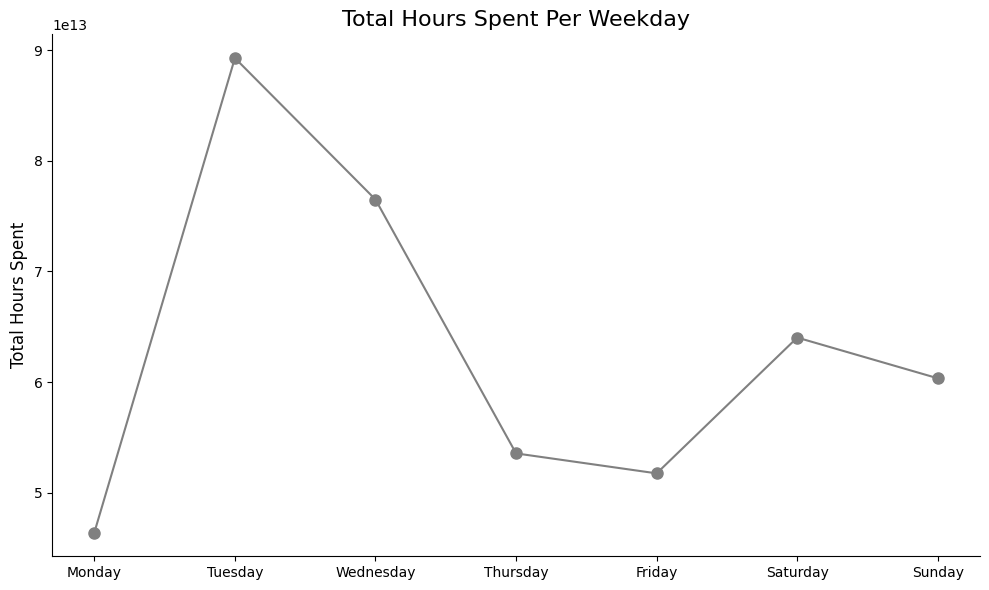

In [15]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# plotting a line chart
plt.figure(figsize=(10, 6))
plt.plot(duration_per_weekday, marker='o', color='gray', linestyle='-', markersize=8)

# adding titles, labels and making it cleaner
plt.title('Total Hours Spent Per Weekday', fontsize=16)
plt.ylabel('Total Hours Spent', fontsize=12)
plt.xticks(ticks = range(7), labels = weekday_labels)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [16]:
# time watching tv shows vs movies
user_data['type'] = user_data['Title'].apply(
    lambda x: 'tvshow' if 'Episódio' in x else 
    ('trailer' if any(keyword in x for keyword in ['Trailer', 'Clipe', 'Teaser', 'hook']) else 'movie')
)
user_data['Duration_hours'] = user_data['Duration'].dt.total_seconds() / 3600
types_of_videos = user_data.groupby('type')['Duration_hours'].sum()
types_of_videos

type
movie       909.338056
trailer       3.686389
tvshow     2984.755278
Name: Duration_hours, dtype: float64

In [20]:
# movies most rewatched
# fileting for lenght on bookmark to increase the odds the movie was completed
filtered_movies_for_lenght = user_data[(user_data['type'] == 'movie') & (user_data['Bookmark'] >= '1:30:00')]
filtered_movies_for_lenght
counts_movies= filtered_movies_for_lenght['Title'].value_counts()
counts_movies.sort_values(ascending= False)

Title
O Amor Não Tira Férias           12
Gatos, Fios-Dentais e Amassos     6
Simplesmente Amor                 4
Orgulho e Preconceito             4
Black Mirror: Bandersnatch        4
                                 ..
Mais um Verão Americano           1
Handsome Devil                    1
Meu Eterno Talvez                 1
A la mala                         1
De mal a pior                     1
Name: count, Length: 310, dtype: int64

In [24]:
# time watching tv shows vs movies in 2024
# filtering the year, type and adding up the duration of each row
duration_in_2024 = user_data[(user_data['year']== 2024) 
& (user_data['type'].isin(['tvshow', 'movie']))]['Duration'].sum()

# transforming it into total hours watched in 2024
total_hours_2024= duration_in_2024.total_seconds() / 3600
print(total_hours_2024)

121.19666666666667

In [25]:
# type of content most watched in 2024
types_watched_2024 = user_data[(user_data['year']== 2024) 
& (user_data['type'].isin(['tvshow', 'movie'])) & (user_data['Duration'] > pd.Timedelta(minutes=15))]['type'].value_counts()
print(types_watched_2024)

type
tvshow    145
movie      31
Name: count, dtype: int64


In [26]:
# most watched tv show in 2024
# keeping only values for 2024 and removing rows that recorded trailers, clips
watched_2024 = user_data[(user_data['year']== 2024) 
& (user_data['type'].isin(['tvshow', 'movie']))]
['Title']

# creating a columns with the first 3 words of the title to group occurences of the same show
watched_2024['short_title'] = watched_2024['Title'].apply(lambda x: ' '.join(x.split()[:3]))

# counting the occurences of each short title
watched_2024['short_title'].value_counts()

# the top 3 shows were gossip girl, queer eye, and bojack horseman

<ipython-input-26-33eb03f34363>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watched_2024['short_title'] = watched_2024['Title'].apply(lambda x: ' '.join(x.split()[:3]))


short_title
Gossip Girl: Temporada            57
Queer Eye: Temporada              25
BoJack Horseman: Temporada        23
Casamento às Cegas:               22
Quem Vê Casa...:                  14
Dominando Manhattan: Temporada    12
Bridgerton: Temporada 3:          10
Amor no Espectro:                  9
Emily em Paris:                    9
Manual de Assassinato              6
De Volta aos                       6
Ninguém Quer: Temporada            6
O Retorno de                       5
O Natal Volta                      5
As Férias da                       4
No Such Thing                      4
O Casal Perfeito:                  4
Costa!! - The                      3
Relive Moments of                  3
Explorando o Desconhecido:         2
Black Doves: Temporada             2
Moving On                          2
O Homem com                        2
O Amor Não                         2
Tudo em Família                    2
Anyone But You                     2
Amor em Soweto            